In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torchvision import models

from sklearn.metrics import confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import numpy as np
import cv2
from tqdm import tqdm

from evaluate import calculate_miou, plot_training_history

from datetime import datetime
from time import time

In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, augment=False, resize_dim=(256, 512)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.files = sorted(os.listdir(img_dir))

        self.resize_dim = resize_dim
        self.augment = augment

        # Augmentations
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10,
                               border_mode=cv2.BORDER_CONSTANT, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.transform_no_aug = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask_file = name.replace(".jpg", ".png")
        mask = cv2.imread(os.path.join(self.mask_dir, mask_file), 0)

        img = cv2.resize(img, self.resize_dim)
        mask = cv2.resize(mask, self.resize_dim,
                          interpolation=cv2.INTER_NEAREST)

        if self.augment:
            t = self.transform(image=img, mask=mask)
        else:
            t = self.transform_no_aug(image=img, mask=mask)

        img = t["image"].float()
        mask = torch.tensor(t["mask"], dtype=torch.long)

        return img, mask


# ==========================================================
# U-NET (ResNet34 backbone)
# ==========================================================
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.pool = resnet.maxpool
        self.enc1 = resnet.layer1
        self.enc2 = resnet.layer2
        self.enc3 = resnet.layer3
        self.enc4 = resnet.layer4

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(True),
            )

        self.up4 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec4 = block(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec3 = block(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = block(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 64, 2, 2)
        self.dec1 = block(64 + 64, 64)

        self.up0 = nn.ConvTranspose2d(64, 64, 2, 2)

        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e0 = self.enc0(x)
        e1 = self.enc1(self.pool(e0))
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        d4 = self.dec4(torch.cat([self.up4(e4), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e1], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e0], dim=1))
        d0 = self.up0(d1)

        return self.final(d0)

In [3]:
criterion = nn.CrossEntropyLoss(ignore_index=255)  # Ignore index 255


def compute_metrics(pred, target, n_classes, ignore_index=255):
    """
    Hitung Accuracy, mPrecision, mRecall, mF1/Dice, dan mIoU.
    Menerima input tensor yang sudah di-flattened.
    """
    # Filter out ignore_index
    valid_mask = (target != ignore_index).cpu().numpy().flatten()
    pred_flat = pred.cpu().numpy().flatten()[valid_mask]
    target_flat = target.cpu().numpy().flatten()[valid_mask]

    if len(pred_flat) == 0:
        return {'mIoU': 0.0, 'mPrecision': 0.0, 'mRecall': 0.0, 'mF1': 0.0, 'Accuracy': 0.0, 'Per_Class': {}}

    # Create confusion matrix
    cm = confusion_matrix(target_flat, pred_flat, labels=np.arange(n_classes))

    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP

    per_class_metrics = {}
    ious, precisions, recalls, f1_scores = [], [], [], []

    for cls in range(n_classes):
        # Handle class not present in GT or Prediction
        if (TP[cls] + FN[cls]) == 0 and (TP[cls] + FP[cls]) == 0:
            continue

        # IoU
        union = TP[cls] + FP[cls] + FN[cls]
        iou = TP[cls] / union if union > 0 else np.nan
        ious.append(iou)

        # Precision
        precision = TP[cls] / (TP[cls] + FP[cls]
                               ) if (TP[cls] + FP[cls]) > 0 else np.nan
        precisions.append(precision)

        # Recall
        recall = TP[cls] / (TP[cls] + FN[cls]
                            ) if (TP[cls] + FN[cls]) > 0 else np.nan
        recalls.append(recall)

        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if not np.isnan(
            precision) and not np.isnan(recall) and (precision + recall) > 0 else np.nan
        f1_scores.append(f1)

        per_class_metrics[cls] = {
            'Precision': precision, 'Recall': recall, 'F1': f1, 'IoU': iou}

    # Mean Metrics
    m_precision = np.nanmean(precisions) if precisions else 0.0
    m_recall = np.nanmean(recalls) if recalls else 0.0
    m_f1 = np.nanmean(f1_scores) if f1_scores else 0.0
    m_iou = np.nanmean(ious) if ious else 0.0

    # Overall Accuracy (Pixel Accuracy)
    accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0.0

    return {'mIoU': m_iou, 'mPrecision': m_precision, 'mRecall': m_recall, 'mF1': m_f1, 'Accuracy': accuracy, 'Per_Class': per_class_metrics}

In [4]:
def calculate_miou(preds, masks, num_classes):
    preds = torch.argmax(preds, dim=1)

    preds_np = preds.cpu().numpy().flatten()
    masks_np = masks.cpu().numpy().flatten()

    conf = np.zeros((num_classes, num_classes))

    for p, t in zip(preds_np, masks_np):
        if 0 <= t < num_classes:
            conf[t, p] += 1

    IoUs = []
    for c in range(num_classes):
        TP = conf[c, c]
        FP = conf[:, c].sum() - TP
        FN = conf[c, :].sum() - TP

        denom = TP + FP + FN
        iou = TP / denom if denom != 0 else 0
        IoUs.append(iou)

    return np.mean(IoUs)


# ========================================================
# TRAINING LOOP (FULL WITH HISTORY)
# ========================================================
def train_model(model, train_loader, val_loader, optimizer, scheduler,
                ce_loss, dice_loss, num_classes, epochs, device):

    best_miou = 0.0
    scaler = GradScaler()

    train_history = {
        "train_acc": [],
        "train_loss": [],
        "val_acc": [],
        "val_loss": [],
        "val_miou": []
    }

    print(f"\n[INFO] Training started\n")

    for epoch in range(epochs):

        # =====================================================
        # TRAINING
        # =====================================================
        model.train()
        total_loss = 0
        correct_pixels = 0
        total_pixels = 0

        train_bar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs} Training", ncols=100)

        for imgs, masks in train_bar:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()

            with autocast("cuda"):
                preds = model(imgs)
                loss = ce_loss(preds, masks) + 0.5 * dice_loss(preds, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            pred_labels = torch.argmax(preds, dim=1)
            correct_pixels += (pred_labels == masks).sum().item()
            total_pixels += masks.numel()

            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_pixels / total_pixels

        # =====================================================
        # VALIDATION
        # =====================================================
        model.eval()
        val_loss = 0

        all_preds = []
        all_masks = []

        with torch.no_grad():
            val_bar = tqdm(
                val_loader, desc=f"Epoch {epoch+1}/{epochs} Validating", ncols=100)
            for imgs, masks in val_bar:
                imgs, masks = imgs.to(device), masks.to(device)

                preds = model(imgs)
                loss = ce_loss(preds, masks) + 0.5 * dice_loss(preds, masks)
                val_loss += loss.item()

                preds_argmax = torch.argmax(preds, dim=1)
                all_preds.append(preds_argmax.cpu().view(-1))
                all_masks.append(masks.cpu().view(-1))

        avg_val_loss = val_loss / len(val_loader)

        # gabungkan semua batch
        all_preds = torch.cat(all_preds)
        all_masks = torch.cat(all_masks)

        metrics = compute_metrics(all_preds, all_masks, num_classes)

        val_accuracy = metrics["Accuracy"]
        val_miou = metrics["mIoU"]

        # =====================================================
        # LOGGING
        # =====================================================
        print(
            f"\nEpoch {epoch+1}/{epochs}\n"
            f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}\n"
            f"Val   Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}\n"
            f"Val   mIoU: {val_miou:.4f} | Val F1: {metrics['mF1']:.4f}"
        )

        scheduler.step()

        # HISTORY SAVE
        train_history["train_loss"].append(avg_train_loss)
        train_history["train_acc"].append(train_accuracy)
        train_history["val_loss"].append(avg_val_loss)
        train_history["val_acc"].append(val_accuracy)
        train_history["val_miou"].append(val_miou)

        # SAVE BEST MODEL
        if val_miou > best_miou:
            best_miou = val_miou
            os.makedirs("result_unet", exist_ok=True)
            torch.save(model.state_dict(), "result_unet/best_unet_model.pth")
            print(f"💾 Saved new best model! mIoU = {best_miou:.4f}")

    print("\nTraining Finished!\n")
    plot_training_history(train_history)
    return metrics


class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, targets, smooth=1e-6):
        preds = torch.softmax(preds, dim=1)
        preds = preds.argmax(dim=1)

        intersection = (preds == targets).sum().float()
        union = preds.numel() + targets.numel()

        return 1 - (2 * intersection + smooth) / (union + smooth)

d:\Learning\AI_Indonesia\project_3\Self-Driving-Car\seg_env\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



[INFO] Training started



Epoch 1/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 1/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 20.81it/s]



Epoch 1/30
Train Loss: 2.1529 | Train Acc: 0.6135
Val   Loss: 1.7902 | Val Acc: 0.6485
Val   mIoU: 0.2126 | Val F1: 0.2990
💾 Saved new best model! mIoU = 0.2126


Epoch 2/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 2/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 21.14it/s]



Epoch 2/30
Train Loss: 1.3162 | Train Acc: 0.7438
Val   Loss: 1.2250 | Val Acc: 0.7732
Val   mIoU: 0.2581 | Val F1: 0.5798
💾 Saved new best model! mIoU = 0.2581


Epoch 3/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 3/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 20.70it/s]



Epoch 3/30
Train Loss: 1.0190 | Train Acc: 0.7727
Val   Loss: 1.0222 | Val Acc: 0.7879
Val   mIoU: 0.2671 | Val F1: 0.8877
💾 Saved new best model! mIoU = 0.2671


Epoch 4/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 4/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 21.04it/s]



Epoch 4/30
Train Loss: 0.8769 | Train Acc: 0.7850
Val   Loss: 0.9171 | Val Acc: 0.7731
Val   mIoU: 0.2628 | Val F1: 0.8787


Epoch 5/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 5/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 20.80it/s]



Epoch 5/30
Train Loss: 0.7797 | Train Acc: 0.7909
Val   Loss: 0.7624 | Val Acc: 0.7880
Val   mIoU: 0.2708 | Val F1: 0.8943
💾 Saved new best model! mIoU = 0.2708


Epoch 6/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 6/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 21.26it/s]



Epoch 6/30
Train Loss: 0.7060 | Train Acc: 0.7951
Val   Loss: 0.6697 | Val Acc: 0.8050
Val   mIoU: 0.2941 | Val F1: 0.6584
💾 Saved new best model! mIoU = 0.2941


Epoch 7/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 7/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 20.91it/s]



Epoch 7/30
Train Loss: 0.6248 | Train Acc: 0.8256
Val   Loss: 0.5772 | Val Acc: 0.8658
Val   mIoU: 0.3625 | Val F1: 0.8013
💾 Saved new best model! mIoU = 0.3625


Epoch 8/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 8/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 21.17it/s]



Epoch 8/30
Train Loss: 0.5419 | Train Acc: 0.8628
Val   Loss: 0.5372 | Val Acc: 0.8766
Val   mIoU: 0.4041 | Val F1: 0.7595
💾 Saved new best model! mIoU = 0.4041


Epoch 9/30 Training:   0%|                                                   | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 9/30 Validating: 100%|████████████████████████████████████████| 26/26 [00:01<00:00, 20.92it/s]



Epoch 9/30
Train Loss: 0.4708 | Train Acc: 0.8845
Val   Loss: 0.5125 | Val Acc: 0.8786
Val   mIoU: 0.4114 | Val F1: 0.7729
💾 Saved new best model! mIoU = 0.4114


Epoch 10/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 10/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.87it/s]



Epoch 10/30
Train Loss: 0.4222 | Train Acc: 0.8994
Val   Loss: 0.4838 | Val Acc: 0.8816
Val   mIoU: 0.4365 | Val F1: 0.8137
💾 Saved new best model! mIoU = 0.4365


Epoch 11/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 11/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.12it/s]



Epoch 11/30
Train Loss: 0.3828 | Train Acc: 0.9131
Val   Loss: 0.4791 | Val Acc: 0.8800
Val   mIoU: 0.4357 | Val F1: 0.8157


Epoch 12/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 12/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.19it/s]



Epoch 12/30
Train Loss: 0.3588 | Train Acc: 0.9176
Val   Loss: 0.4698 | Val Acc: 0.8808
Val   mIoU: 0.4381 | Val F1: 0.8172
💾 Saved new best model! mIoU = 0.4381


Epoch 13/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 13/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.79it/s]



Epoch 13/30
Train Loss: 0.3425 | Train Acc: 0.9201
Val   Loss: 0.4791 | Val Acc: 0.8768
Val   mIoU: 0.4360 | Val F1: 0.8163


Epoch 14/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 14/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.68it/s]



Epoch 14/30
Train Loss: 0.3335 | Train Acc: 0.9210
Val   Loss: 0.4662 | Val Acc: 0.8788
Val   mIoU: 0.4380 | Val F1: 0.8167


Epoch 15/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 15/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.93it/s]



Epoch 15/30
Train Loss: 0.3184 | Train Acc: 0.9225
Val   Loss: 0.4675 | Val Acc: 0.8773
Val   mIoU: 0.4399 | Val F1: 0.8204
💾 Saved new best model! mIoU = 0.4399


Epoch 16/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 16/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.79it/s]



Epoch 16/30
Train Loss: 0.3068 | Train Acc: 0.9242
Val   Loss: 0.4698 | Val Acc: 0.8746
Val   mIoU: 0.4403 | Val F1: 0.8215
💾 Saved new best model! mIoU = 0.4403


Epoch 17/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 17/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.95it/s]



Epoch 17/30
Train Loss: 0.2985 | Train Acc: 0.9250
Val   Loss: 0.4633 | Val Acc: 0.8771
Val   mIoU: 0.4401 | Val F1: 0.8184


Epoch 18/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 18/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.91it/s]



Epoch 18/30
Train Loss: 0.2916 | Train Acc: 0.9257
Val   Loss: 0.4738 | Val Acc: 0.8734
Val   mIoU: 0.4337 | Val F1: 0.8132


Epoch 19/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 19/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.09it/s]



Epoch 19/30
Train Loss: 0.2846 | Train Acc: 0.9263
Val   Loss: 0.4652 | Val Acc: 0.8752
Val   mIoU: 0.4421 | Val F1: 0.8250
💾 Saved new best model! mIoU = 0.4421


Epoch 20/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 20/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.04it/s]



Epoch 20/30
Train Loss: 0.2759 | Train Acc: 0.9279
Val   Loss: 0.4615 | Val Acc: 0.8758
Val   mIoU: 0.4390 | Val F1: 0.8182


Epoch 21/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 21/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.87it/s]



Epoch 21/30
Train Loss: 0.2668 | Train Acc: 0.9293
Val   Loss: 0.4647 | Val Acc: 0.8749
Val   mIoU: 0.4421 | Val F1: 0.8235
💾 Saved new best model! mIoU = 0.4421


Epoch 22/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 22/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.00it/s]



Epoch 22/30
Train Loss: 0.2613 | Train Acc: 0.9302
Val   Loss: 0.4669 | Val Acc: 0.8751
Val   mIoU: 0.4417 | Val F1: 0.8231


Epoch 23/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 23/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.95it/s]



Epoch 23/30
Train Loss: 0.2582 | Train Acc: 0.9306
Val   Loss: 0.4668 | Val Acc: 0.8745
Val   mIoU: 0.4402 | Val F1: 0.8211


Epoch 24/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 24/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.68it/s]



Epoch 24/30
Train Loss: 0.2533 | Train Acc: 0.9311
Val   Loss: 0.4635 | Val Acc: 0.8750
Val   mIoU: 0.4415 | Val F1: 0.8227


Epoch 25/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 25/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.00it/s]



Epoch 25/30
Train Loss: 0.2510 | Train Acc: 0.9313
Val   Loss: 0.4638 | Val Acc: 0.8751
Val   mIoU: 0.4444 | Val F1: 0.8256
💾 Saved new best model! mIoU = 0.4444


Epoch 26/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 26/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.08it/s]



Epoch 26/30
Train Loss: 0.2477 | Train Acc: 0.9317
Val   Loss: 0.4720 | Val Acc: 0.8734
Val   mIoU: 0.4399 | Val F1: 0.8211


Epoch 27/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 27/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.07it/s]



Epoch 27/30
Train Loss: 0.2449 | Train Acc: 0.9319
Val   Loss: 0.4662 | Val Acc: 0.8746
Val   mIoU: 0.4422 | Val F1: 0.8243


Epoch 28/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 28/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 21.00it/s]



Epoch 28/30
Train Loss: 0.2438 | Train Acc: 0.9318
Val   Loss: 0.4681 | Val Acc: 0.8739
Val   mIoU: 0.4384 | Val F1: 0.8196


Epoch 29/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 29/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.82it/s]



Epoch 29/30
Train Loss: 0.2393 | Train Acc: 0.9323
Val   Loss: 0.4675 | Val Acc: 0.8748
Val   mIoU: 0.4391 | Val F1: 0.8202


Epoch 30/30 Training:   0%|                                                  | 0/92 [00:00<?, ?it/s]C:\Users\muhar\AppData\Local\Temp\ipykernel_31672\2199257229.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(t["mask"], dtype=torch.long)
Epoch 30/30 Validating: 100%|███████████████████████████████████████| 26/26 [00:01<00:00, 20.98it/s]



Epoch 30/30
Train Loss: 0.2355 | Train Acc: 0.9329
Val   Loss: 0.4623 | Val Acc: 0.8752
Val   mIoU: 0.4423 | Val F1: 0.8235

Training Finished!

Saved history


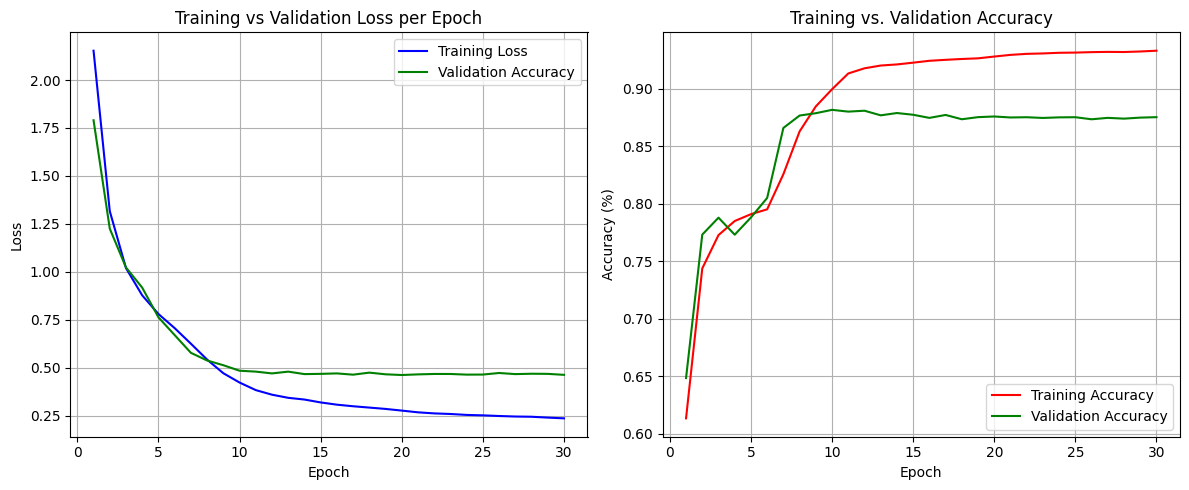

In [7]:
num_classes = 12
# contoh, sesuaikan dataset-mu
epochs = 30
device = "cuda"

train_dataset = SegmentationDataset(
    "dataset/train/images", "dataset/train/masks")
val_dataset = SegmentationDataset(
    "dataset/val/images",   "dataset/val/masks")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
model = UNet(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

ce_loss = torch.nn.CrossEntropyLoss()
dice_loss = DiceLoss()   # kalau kamu punya

val_metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    ce_loss=ce_loss,
    dice_loss=dice_loss,
    num_classes=num_classes,
    epochs=epochs,
    device=device
)

In [8]:
val_metrics

{'mIoU': np.float64(0.4423441905936123),
 'mPrecision': np.float64(0.6960574185996697),
 'mRecall': np.float64(0.5219644115802499),
 'mF1': np.float64(0.823518595995964),
 'Accuracy': np.float64(0.8751896773234452),
 'Per_Class': {0: {'Precision': np.float64(0.9521891938480397),
   'Recall': np.float64(0.9780936930526603),
   'F1': np.float64(0.9649676235704774),
   'IoU': np.float64(0.9323067041624895)},
  1: {'Precision': np.float64(0.9241266542826295),
   'Recall': np.float64(0.9077032304896819),
   'F1': np.float64(0.9158413195974555),
   'IoU': np.float64(0.8447484082841146)},
  2: {'Precision': np.float64(0.0),
   'Recall': np.float64(0.0),
   'F1': nan,
   'IoU': np.float64(0.0)},
  3: {'Precision': np.float64(0.9755490129807308),
   'Recall': np.float64(0.9783625158084109),
   'F1': np.float64(0.9769537387659677),
   'IoU': np.float64(0.9549458082057148)},
  4: {'Precision': np.float64(0.8774319081561269),
   'Recall': np.float64(0.9585415545142814),
   'F1': np.float64(0.91619

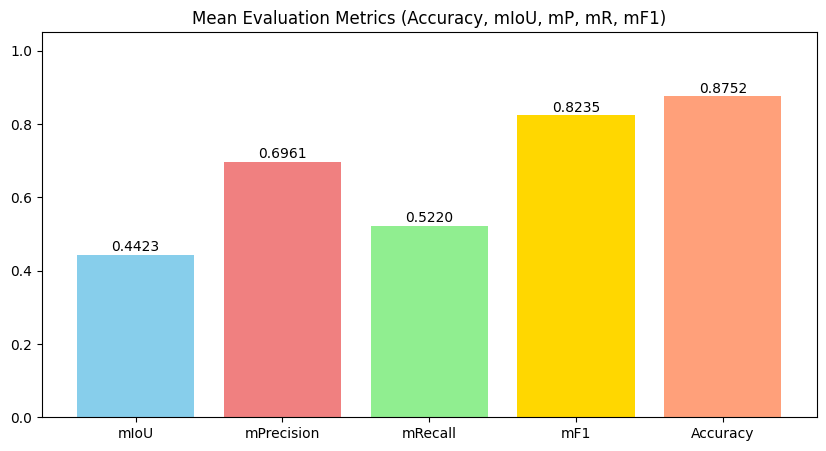

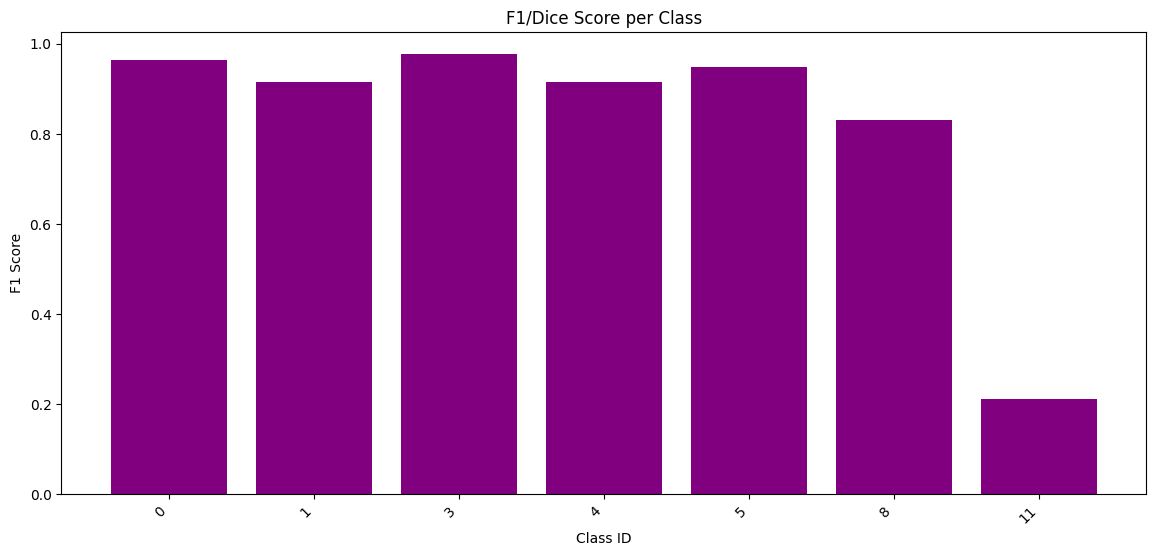

In [ ]:
THIS_DIR = os.getcwd()
save_path = os.path.join(THIS_DIR, "evaluate_unet")
os.makedirs(save_path, exist_ok=True)

if val_metrics:
    # 1. Bar Plot untuk Mean Metrics (Accuracy, mIoU, mPrecision, mRecall, mF1)
    mean_metrics = {k: v for k, v in val_metrics.items(
    ) if k in ['Accuracy', 'mIoU', 'mPrecision', 'mRecall', 'mF1']}

    plt.figure(figsize=(10, 5))
    metrics_names = list(mean_metrics.keys())
    metrics_values = [mean_metrics[k] for k in metrics_names]

    # Filter NaN (jika ada)
    valid_metrics_values = [float(v)
                            for v in metrics_values if not np.isnan(v)]
    valid_metrics_names = [metrics_names[i]
                           for i, v in enumerate(metrics_values) if not np.isnan(v)]

    plt.bar(valid_metrics_names, valid_metrics_values, color=[
            'skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightsalmon'])

    for i, v in enumerate(valid_metrics_values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

    plt.ylim(0, 1.05)
    plt.title('Mean Evaluation Metrics (Accuracy, mIoU, mP, mR, mF1)')
    plt.show()

    # 2. Bar Plot Per-Class F1 Score
    per_class = val_metrics['Per_Class']
    class_labels = sorted(per_class.keys())
    f1_scores = [per_class[cls].get('F1') for cls in class_labels]

    valid_f1_scores = [f for f in f1_scores if not np.isnan(f)]
    valid_class_labels = [cls for cls, f in zip(
        class_labels, f1_scores) if not np.isnan(f)]

    if valid_f1_scores:
        plt.figure(figsize=(14, 6))
        plt.bar([str(c) for c in valid_class_labels],
                valid_f1_scores, color='purple')
        plt.title('F1/Dice Score per Class')
        plt.xlabel('Class ID')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45, ha='right')
        
        plt.savefig(f"{save_path}/evaluasi_metrics.png")
        plt.show()
    else:
        print("No valid F1 Scores to plot per class.")
else:
    print("Metrics not available. Run the training cell first.")